In [1]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
from dataclasses import *
import numpy as np
from typing import Dict 
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
import scipy.integrate as integrate
from EnforceTyping import EnforceClassTyping, enforce_method_typing, enforce_function_typing
from ParticlesandFields import ClassicalField, ClassicalParticle

In [2]:
@dataclass(kw_only=True)
class ElectrostaticField2D(ClassicalField):
  """
  A class used to represent a 2D Electrostatic Field

  Attributes
  ----------
  field_sources: dict
      a formatted string to print out what the animal says
  dimensionality: tuple
      a tuple of the dimensionality of the field  

  Methods
  -------
  dynamics(self, observation_position: np.ndarray, time: float) -> np.ndarray:
      Represents the value of the field at any given point(s) or time. 
  potential(self, observation_position: np.ndarray, time: float) -> float:
      Represents the potential due to the field at a given position and/or time  
  potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray, time: float) -> float:
      Represents the potential difference between two positions at a given time in the vector field   
  gradient(self, observation_position: np.ndarray, time: float) -> float:
      Represents the gradient at a given position and/or time in the vector field 
  curl(self, observation_position: np.ndarray, time: float) -> float:
      Represents the curl at a given position and/or time in the vector field 
  divergence(self, observation_position: np.ndarray, time: float) -> float:
      Represents the divergence at a given position and/or time in the vector field
  """
  field_sources: dict
  dimensionality: tuple = (2,)

  def __call__(self, observation_position: np.ndarray) -> np.ndarray:
      return self.dynamics(observation_position)

  @enforce_method_typing
  def dynamics(self, observation_position: np.ndarray) -> np.ndarray:
      """
      This function outputs the field strength due to field sources experienced at any given point(s) or time. 
      This determines the physics of the field (a 2D Electricstatic Field in this case)

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric field strength vector at the given position.
      """
      assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
      for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle"
      coulomb_constant = 8.9875e9  # N*m^2/C^2
      electric_field_vector = np.zeros_like(observation_position)
      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_matrices = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vector = observation_position - position_matrices
          displacement_magnitude = np.linalg.norm(displacement_vector, axis=0)
          electric_field_vector += (displacement_vector * field_source.charge) / displacement_magnitude**3
      electric_field_vector = coulomb_constant * electric_field_vector
      return np.round(electric_field_vector, 3)  # N/C or V/m

  @enforce_method_typing
  def potential(self, observation_position: np.ndarray) -> float:
      """
      Calculate the potential (voltage) at a position in the field.

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric potential at the given position.
      """
      assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
      for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle"
  
      coulomb_constant = 8.9875e9  # N*m^2/C^2
      electric_potential = 0.0

      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_matrices = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vector = observation_position - position_matrices
          displacement_magnitude = np.linalg.norm(displacement_vector, axis=0)
          electric_potential += field_source.charge / displacement_magnitude

      electric_potential = coulomb_constant * electric_potential
      return np.round(electric_potential, 3)  # V

  @enforce_method_typing
  def potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray) -> float:
    """
    Calculate the potential difference between the initial position and the final position in the field.

    Args:
        initial_position (np.ndarray): The starting position.
        final_position (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    assert initial_position.shape == self.dimensionality, "initial_position has the wrong dimensions"
    assert final_position.shape == self.dimensionality, "final_position has the wrong dimensions"
    PorentialDifference= self.potential(initial_position)- self.potential(final_position)
    return PorentialDifference

  def gradient(self, observation_position: np.ndarray, delta: float= 0.001)->np.ndarray:
    """
    This function returns the derivative of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    gradient= np.zeros_like(observation_position)
    for i in range(len(observation_position)):
      di= np.zeros_like(observation_position)
      di[i, ] = di[i, ]+delta
      plusdi= observation_position+ di
      minusdi= observation_position- di
      gradient[i]= (self.dynamics(plusdi)- self.dynamics(minusdi))[i]/ (2* delta)
    return gradient
  
  def curl(self, observation_position: np.ndarray)-> float:
    """
    This function returns the curl of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  
  def divergence(self, observation_position: np.ndarray)-> float:
    """
    This function returns the divergence of the field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  @enforce_method_typing
  def plot_field(self, low_bound= -5, high_bound= 5):
    """
    This funtion plots the 2D electric vector field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    observation_position= np.meshgrid(np.linspace(low_bound, high_bound, 25), 
                                    np.linspace(low_bound, high_bound, 25))
    observation_position= np.stack(observation_position)
    xd, yd = self.dynamics(observation_position)
    xd = xd / np.sqrt(xd**2 + yd**2)
    yd = yd / np.sqrt(xd**2 + yd**2)
    color_aara = np.sqrt(xd**2+ yd**2)
    fig, ax = plt.subplots(1,1)
    cp = ax.quiver(observation_position[0],observation_position[1],xd,yd,color_aara)
    fig.colorbar(cp)
    plt.rcParams['figure.dpi'] = 150
    plt.show()

**Examples of Other Fields**

In [3]:

class HomogenousField(Field):
  
  def FieldStrength(self, ObservationPosition: np.ndarray)-> np.ndarray:
    return  np.zeros((ObservationPosition.shape[0], self.Dimensions), dtype=np.float64)
  def FieldPotential(self, ObservationPosition: np.ndarray)-> float:
    return  0.0

@dataclass(kw_only= True)
class LJField(Field):
    FieldSources: list[ClassicalParticle]
    FieldHighBound: float
    FieldLowBound: float
    def __call__(self, ObservationPosition: np.ndarray)->np.ndarray:
        return self.FieldStrength(ObservationPosition)
    @enforce_method_typing
    def FieldStrength(self, ObservationPosition: np.ndarray)->np.ndarray:
        'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
        CoulombConstant = 8.9875e9 #N*m^2/C^2
        for FieldSource in self.FieldSources:
            if type(FieldSource) != ClassicalParticle:
                raise TypeError("The input is not valid")
        assert type(ObservationPosition) == np.ndarray, "Invalid Reference point data type"
        ElectricFieldVector = np.zeros_like(ObservationPosition)
        for FieldSource in self.FieldSources:
            PositionMatrices= np.stack([np.ones_like(ObservationPosition[0])* FieldSource.Position[0].item(), 
                                            np.ones_like(ObservationPosition[1])* FieldSource.Position[1].item()])
            DisplacementVector = ObservationPosition - PositionMatrices
            DisplacementMagnitude = np.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
            ElectricFieldVector += ((FieldSource.Charge) / DisplacementMagnitude**3 * DisplacementVector) - ((FieldSource.Charge) / DisplacementMagnitude**6 * DisplacementVector)
        ElectricFieldVector= CoulombConstant *ElectricFieldVector
        return ElectricFieldVector #N/C or V/m
    @enforce_method_typing
    def FieldPotential(self, InitialPosition: np.ndarray, FinalPosition: np.ndarray, resolution: int= 5000)-> float:
        '''This method determines the amount of work required to get one position to another in the field'''
        XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
        YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
        XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
        YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
        WorkDone = 0
        for i in range(resolution):
            PositionFieldStrength = self.ForceFieldStrength(np.array([XPositions[i], YPositions[i]]))
            WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
        return WorkDone
    @enforce_method_typing
    def PlotField(self):
        'This funtion plots the 2D electric vector field'
        ObservationPosition= np.meshgrid(np.linspace(self.FieldLowBound, self.FieldHighBound, 40), 
                                        np.linspace(self.FieldLowBound, self.FieldHighBound, 40))
        ObservationPosition= np.stack(ObservationPosition)
        xd, yd = self.ElectricFieldStrength(ObservationPosition)
        xd = xd / np.sqrt(xd**2 + yd**2)
        yd = yd / np.sqrt(xd**2 + yd**2)
        color_aara = np.sqrt(xd**2+ yd**2)
        fig, ax = plt.subplots(1,1)
        cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
        fig.colorbar(cp)
        plt.rcParams['figure.dpi'] = 250
        plt.show()


In [4]:
negative_charge= ClassicalParticle(mass=1.0, charge= -1e-9)
positive_charge= ClassicalParticle(mass=1.0, charge= 1e-9)
sources = {"Particle": [negative_charge, positive_charge],
           "Position": [np.array([1.0, 1.0]), np.array([-1.0, 1.0])]} #Update to accomodate charge density- a function that returns the charge at any point in the field

In [5]:
test_electric_field= ElectrostaticField2D(field_sources=sources)


In [6]:
position1= np.array([0., 0.])
position2= np.array([0., 1.])
test_electric_field_strength= test_electric_field(position1)
test_electric_field_potential= test_electric_field.potential(position1)
test_electric_field_potential_difference= test_electric_field.potential_difference(position1, position2)
test_electric_field_gradient= test_electric_field.gradient(position1)

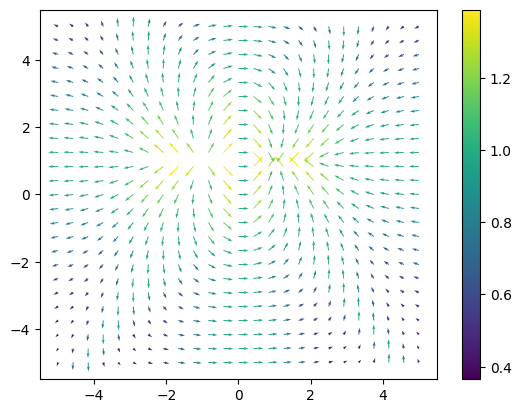

In [7]:
test_electric_field.plot_field()